<a href="https://colab.research.google.com/github/pds2021/a5-crown90/blob/assignment_5/Assignment_5_WebApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Paper Scissors Lizard Spock 

### Gameplan

1. The player has to start/allow the webcam
2. The player adjusts an [ROCK/ PAPER/ SCISSORS/ LIZARD/ SPOCK] by hand
3. The player has to push the [CAPTURE] button
4. The AI player chooses one too and presents its choice to the player
5. The winner will be promoted
6. End of game 

### Game Rules

1. scissors cuts paper
2. paper covers rock
3. rock crushes lizard
4. lizard poisons spock
5. spock smashes scissors
6. scissors decapitates lizard
7. lizard eats paper
8. paper disproves spock
9. spock vaporizes rock
10. rock crushes scissors

### Hands

* SCISSORS: 
> index finger + middle finger
* ROCK: 
> fist
* PAPER:
> flat hand
* LIZARD: 
> index finger up, middle fingers down, pinky up, thumb in: </br> the standard rock 'n' roll salute
* SPOCK: 
> vulcan salute

### Game code

In [42]:
import random

# Number-Hand-Mapping
number_hand_map = {0:"rock", 1:"paper", 2:"scissors", 3:"lizard", 4:"spock"}
hand_number_map = {v: k for k, v in number_hand_map.items()}
 
# Number-Hand win-lose matrix
win_lose_matrix = [[-1, 1, 0, 0, 4],[1, -1, 2, 3, 1], [0, 2, -1, 2, 4], [0, 3, 2, -1, 3], [4, 1, 4, 3, -1]]

def play(player_hand_str):
  player_hand_int = hand_number_map[player_hand_str]
  
  # Get the computer move randomly
  computer_hand_int = random.randint(0, 4)

  # Find the winner of the match
  winner = win_lose_matrix[player_hand_int][computer_hand_int]

  print("You choose", number_hand_map[player_hand_int].upper())
  print("Computer chooses", number_hand_map[computer_hand_int].upper())

  if winner == player_hand_int:
    print("YOU WIN!")
  elif winner == computer_hand_int:
    print("YOU LOSE! COMPUTER WINS!")
  else:
    print("TIE!")

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='player_choice.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Adjust your hand and click to CAPTURE';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [3]:
!pip install -Uqq fastai  # upgrade fastai on colab
from fastai.vision.all import *
from fastai.vision.widgets import *

     |████████████████████████████████| 194kB 8.7MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 


In [4]:
download_url('https://github.com/pds2021/a5-crown90/releases/download/v0.1/export.pkl', 'rock-paper-scissors-lizard-spock.pkl')
learn_inf = load_learner('rock-paper-scissors-lizard-spock.pkl', cpu=True)

### Game

<IPython.core.display.Javascript object>

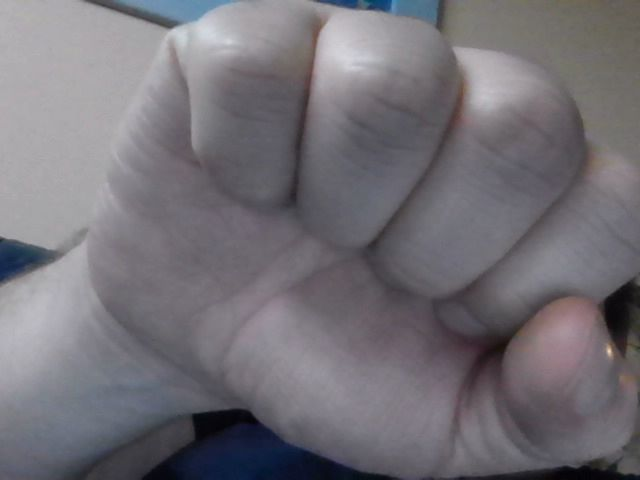


Prediction: rock; Probability: 0.9963
Probability: 0.0005 0.0002 0.9963 0.0000 0.0031

You choose ROCK
Computer chooses SCISSORS
YOU WIN!


In [43]:
from IPython.display import Image
out_pl = widgets.Output()

try:
  filename = take_photo()
  display(Image(filename))

  img = PILImage.create(filename)
  pred,pred_idx,probs = learn_inf.predict(img)
  
  print()
  pred_result = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
  pred_result_all = f'Probabilities: {probs[0]:.04f} {probs[1]:.04f} {probs[2]:.04f} {probs[3]:.04f} {probs[4]:.04f}'
 
  print(pred_result)
  print(pred_result_all)
  print()
  play(pred)

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))